# Neutron Reflectivity Data Analysis



In [1]:
#Imports.

import matplotlib.pyplot as plt
import numpy as np
import os.path
import refnx, scipy
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet
from refnx.dataset import ReflectDataset
import random
from classModel import refModel
import tqdm

np.random.seed(1234)
%matplotlib inline

In [2]:
#Load in data. 

data_d2o = ReflectDataset('d2o.txt')
data_h2o = ReflectDataset('pmw.txt')

#Materials (Scattering Length Density)

d2o_sld = Parameter(6.02, 'd2o SLD', vary=True, bounds= (5,7))
h2o_sld = Parameter(-0.56, 'h2o SLD', vary=True, bounds= (-10,10))

d2o = SLD(d2o_sld) #D2O
h2o = SLD(h2o_sld) #Water
air = SLD(0) #Air

si = SLD(1)
sio2 = SLD(1)

### Varied Parameters

In [3]:
#D2O molar fraction in liquid.

d2o_molfr = Parameter(1 , 'd2o fraction')
d2o_molfr.setp(vary = True, bounds = (0,1))

#Water per hear (Bilayer)

Waters_per_head  = Parameter(7, 'Waters_per_head ')
Waters_per_head.setp(vary=True, bounds=(0, 20))

#Area Per Molecule 

apm = Parameter(100, 'area per molecule', vary=True, bounds=(50, 150))

#Head and tail group thicknesses and roughness.

inner_head_thickness = Parameter(10, 'inner_head_thickness', vary=True, bounds=(0.1, 50))
outer_head_thickness = Parameter(10, 'outer_head_thickness', vary=True, bounds=(0.1, 50))
tail_thickness = Parameter(10, 'tail_thickness', vary=True, bounds=(0.1, 20))
roughness = Parameter(2, 'roughness', vary=True, bounds=(0, 5))

#D2O layer.
d2o_slab = d2o(25, 5)
d2o_slab.thick.setp(vary=True, bounds=(20, 60))
d2o_slab.thick.name = 'd2o thickness'

d2o_slab.rough.setp(vary=True, bounds=(0, 20))
d2o_slab.rough.name = 'd2o roughness'

#H2O layer.
h2o_slab = h2o(25, 5)
h2o_slab.thick.setp(vary=True, bounds=(20, 60))
h2o_slab.thick.name = 'h2o thickness'

h2o_slab.rough.setp(vary=True, bounds=(0, 20))
h2o_slab.rough.name = 'h2o roughness'

#Lipid/solvent interface.
solv_roughness = Parameter(3, 'bilayer/solvent roughness')
solv_roughness.setp(vary=True, bounds=(0, 5))


### Define constants

In [4]:
#Define all the neutron b's
bc = 0.6646e-4;	
bo = 0.5804e-4;	
bh = -0.3739e-4;
bp = 0.513e-4
bn = 0.936e-4
bd = 0.6671e-4

#Formulae of the molecule sections
CH2 = (1*bc) + (2*bh);
CH = (1*bc) + (1*bh);
CH3 = (1*bc) + (3*bh);
D2O = (2*bd) + (1*bo);
H2O = (2*bh) + (1*bo);

wMol = (d2o_molfr * D2O) + ((1-d2o_molfr)*H2O)

### Define layer composition and dimensions

In [5]:
#Bilayer

sum_b_tails = (28*CH2) + (2*CH) + (2*CH3);
sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH);
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh);
sum_b_heads = (1/4)*(3*(sum_popc_heads) + (sum_popg_heads)) + (Waters_per_head * wMol);

vCH2 = 27.7;
nCH2 = 30;
vCH3 = 54.6;
volume_tails = (nCH2 * vCH2) + (2 * vCH3);
volume_heads = 331;


### Construct Layers

In [6]:
#Sum of scattering lengths for the lipid head and tail in Angstrom.

b_heads = Parameter(sum_b_heads, 'b_heads')
b_tails = Parameter(sum_b_tails, 'b_tails')

#Volume occupied by the head and tail groups in cubic Angstrom.

v_heads = Parameter(volume_heads, 'v_heads')
v_tails = Parameter(volume_tails, 'v_tails')

#Bilayer

bilayer_top = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             roughness, roughness)

bilayer_bottom = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             roughness, roughness, reverse_monolayer=True)



### Create structure models

In [7]:
#Bilayer in D2O
struct_d2o = air | bilayer_top | bilayer_bottom | d2o

#Bilayer in H2O
struct_h2o = air | bilayer_top | bilayer_bottom | h2o

scaleargs = dict(vary=True, bounds=(0.5, 2))
bkgargs = dict(vary=True, bounds=(-5e-6, 5e-6))

model_d2o = ReflectModel(struct_d2o)
model_d2o.scale.setp(**scaleargs)
model_d2o.bkg.setp(**bkgargs)

model_h2o = ReflectModel(struct_h2o)
model_h2o.scale.setp(**scaleargs)
model_h2o.bkg.setp(**bkgargs)

### Fit to data

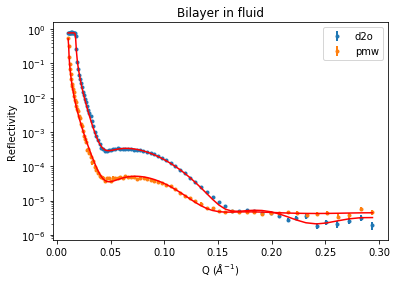

In [8]:
obj_d2o = Objective(model_d2o, data_d2o)
obj_h2o = Objective(model_h2o, data_h2o)
global_obj = GlobalObjective([obj_d2o, obj_h2o])

fitter = CurveFitter(global_obj)
fitter.fit('differential_evolution')

global_obj.plot()
plt.title('Bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.legend();

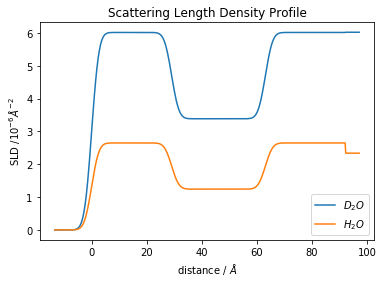

In [9]:
#SLD profile of structure.

plt.plot(*struct_d2o.sld_profile(), label = '$D_2O$')
plt.plot(*struct_h2o.sld_profile(), label = '$H_2O$')
plt.title('Scattering Length Density Profile')
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.legend();

### MCMC

In [10]:
#Burn frist 500, sample every 10th from 2000.

fitter.sample(2000)
process_chain(global_obj, fitter.chain, nburn=500, nthin=10, flatchain=True);

100%|██████████| 2000/2000 [22:41<00:00,  1.47it/s]


/Users/Miron/miniconda3/envs/refnx/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/Miron/miniconda3/envs/refnx/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


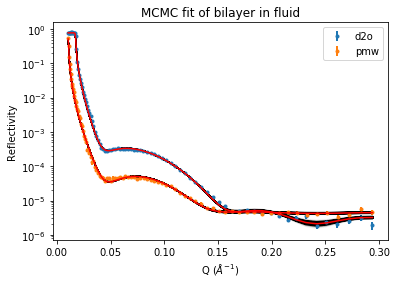

In [11]:
#print(global_obj.parameters)

global_obj.plot(samples = 1500)
plt.title('MCMC fit of bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.legend();

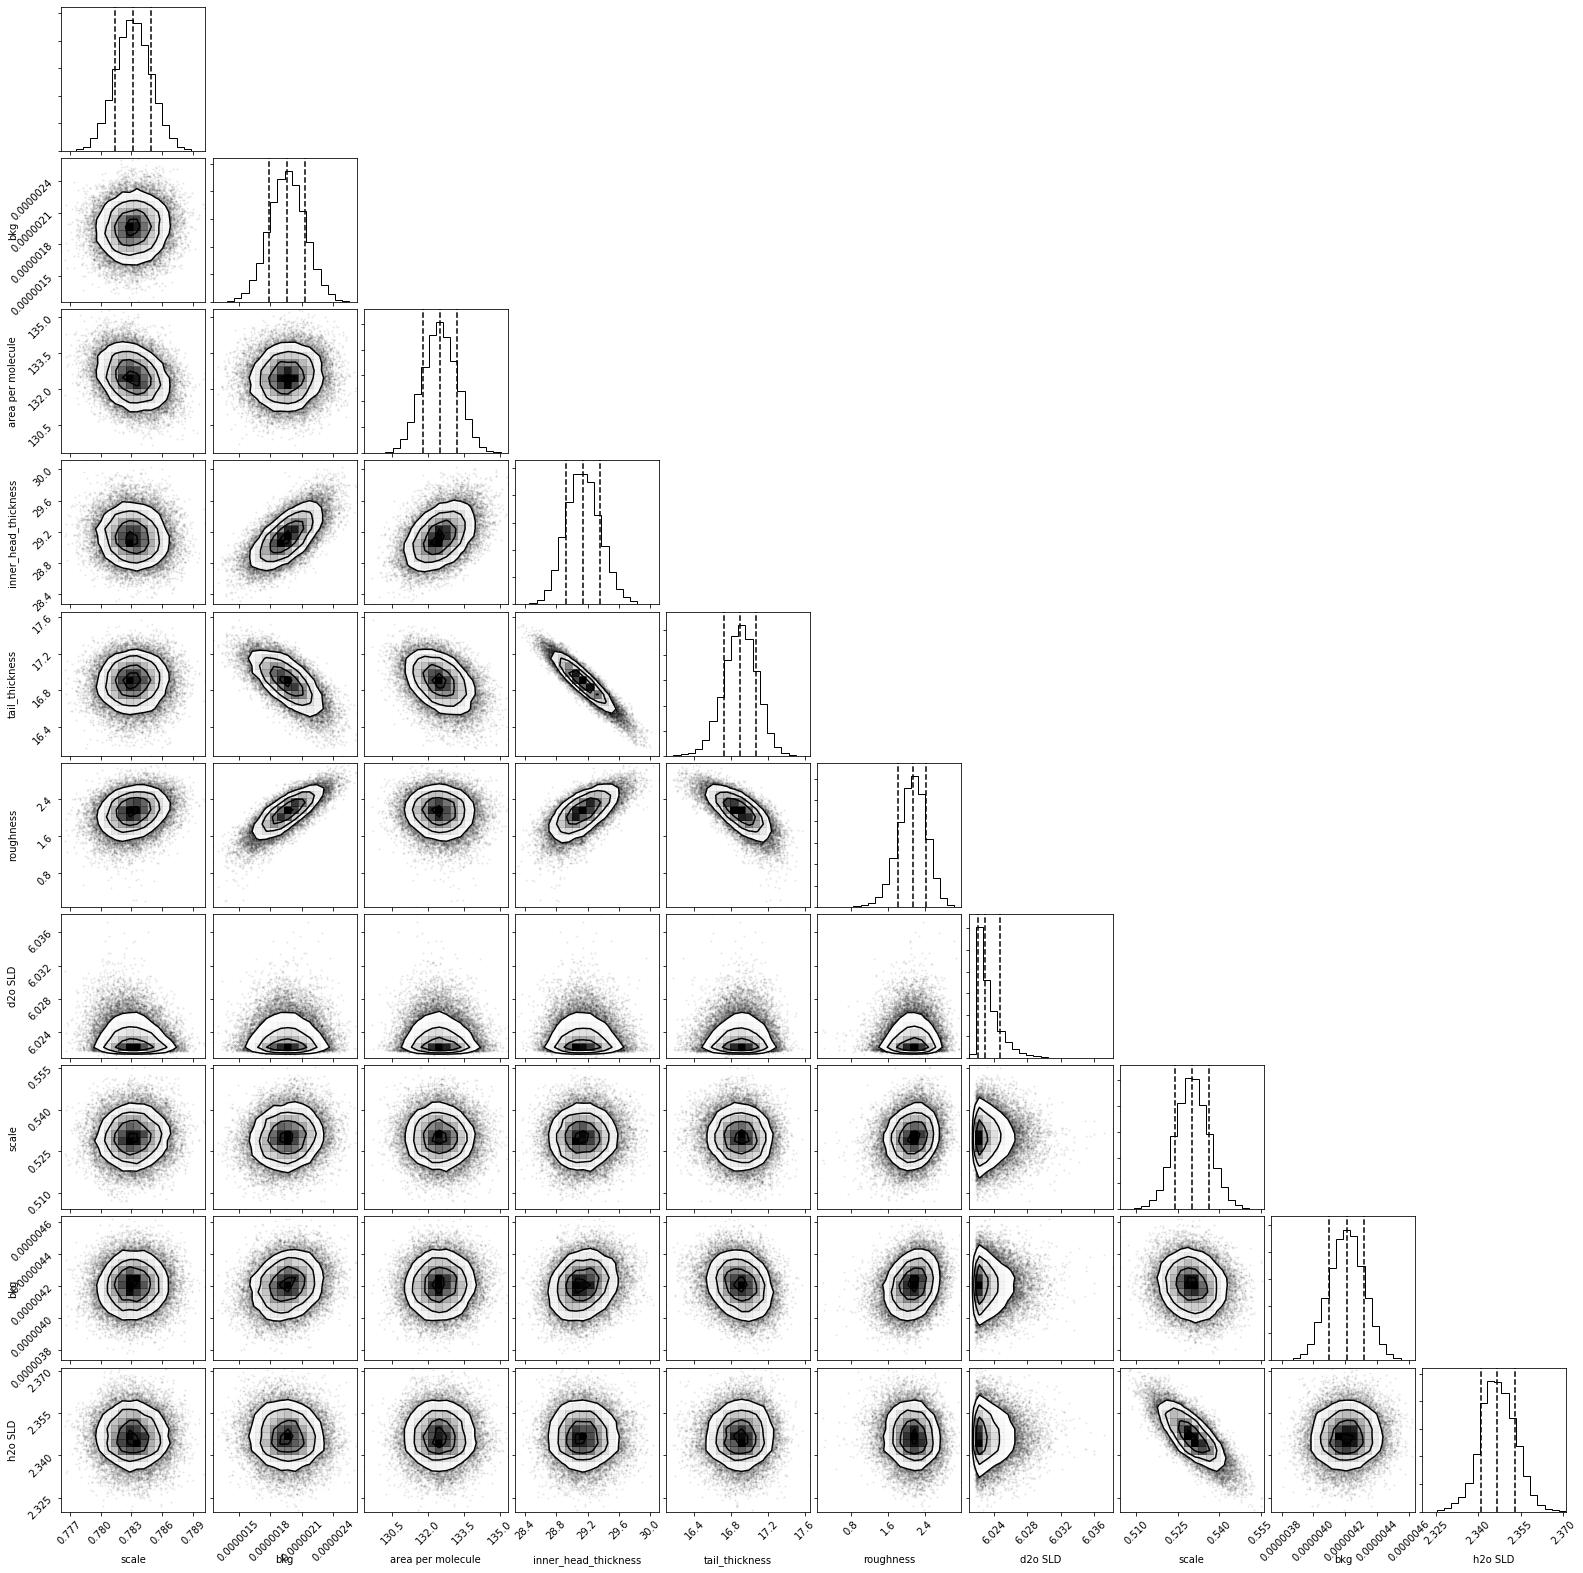

In [12]:
global_obj.corner();

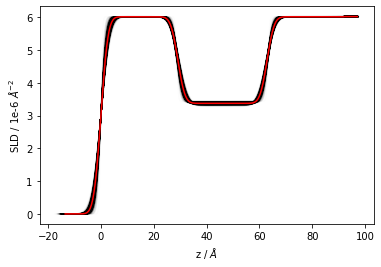

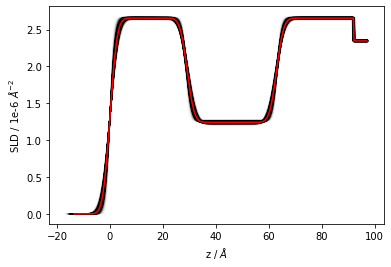

In [13]:
struct_d2o.plot(samples = 1500)
struct_h2o.plot(samples = 1500);